# `s2s_verification_climpred` student project template:  MJO Dependent Forecast Skill

This notebook is part of the [tutorials](https://www.cgd.ucar.edu/events/2021/asp-colloquia/tutorials.html) in the [ASP summer school](https://www.cgd.ucar.edu/events/2021/asp-colloquia/).

In the [S2S verification tutorial](https://docs.google.com/document/d/1nQOyjjAjdqN2sl3IeJYCytCo4l_49GW6fMgkKjsnsCc/edit),
we use `climpred` https://climpred.readthedocs.io/en/stable/ to verify subseasonal-to-seasonal (S2S) forecasts against observations.

---

Intro:

Calculates forecast skill based on the MJO Phase. Currently all rmse but easy enough to change

Requires MJO data from MJO.txt file, as well as the colloquium model data


Level of difficulty:

- country data: easy 🗸
- geospatial data: medium 🗸

by Matt, with help from Jan and Aaron. MJO data provided by Jan

---

Other resources:

- `xarray`: working horse for geospatial data in python
    - documentation: xarray.pydata.org/
    - tutorial: https://xarray-contrib.github.io/xarray-tutorial/
- `xskillscore`: is built on top of `xarray` and provides `metric`s to `climpred`
    - documentation: https://xskillscore.readthedocs.io/en/stable/
    - quick-start: https://mybinder.org/v2/gh/xarray-contrib/xskillscore/master?urlpath=lab
- `climpred`:
    - documentation: https://climpred.readthedocs.io/en/stable/
    - data model: https://climpred.readthedocs.io/en/stable/setting-up-data.html
    - classes: https://climpred.readthedocs.io/en/stable/prediction-ensemble-object.html
    - list of initialized public datasets to work with: https://climpred.readthedocs.io/en/stable/initialized-datasets.html
    - terminology: https://climpred.readthedocs.io/en/stable/terminology.html
    - alignment: https://climpred.readthedocs.io/en/stable/alignment.html
    
--- 

Usage questions? Consider...

- raising an [issue](https://github.com/pangeo-data/climpred/issues), which can be transferred to [discussions](https://github.com/pangeo-data/climpred/discussions)
- reaching out on [slack](asp2021-s2s.slack.com)

In [1]:
import numpy as np
import xarray as xr
import climpred
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)
climpred.set_options(warn_for_failed_PredictionEnsemble_xr_call=False)
import pandas as pd
import cftime

## Get data

Get MJO data from file:

In [2]:
# Get MJO data
mjodata = pd.read_csv('MJO.txt', skipinitialspace=True, sep=' ')

# Convert to xarray indexed by datetime
mjodata['time'] = [(cftime.DatetimeProlepticGregorian(mjodata.year[i],mjodata.month[i],mjodata.day[i])) for i in range(0,mjodata.year.size)]
mjodata = mjodata.drop(columns=['year','month','day']).set_index('time')
mjodata = mjodata.to_xarray()

#print(mjodata)

Import model data as in tutorial notebooks, remove inits past 2020 due to MJO data constraints:

In [3]:
# load model data
model = 'ECMWF' #'CESM2' # ECCC, NCEP  # forecast model
data = 'anom' # raw # anom means anomaly and means that climatology is removed
lead = 'daily' # biweekly  # lead aggregation
dim = 'country' # geospatial  # spatial aggregatation

import intake
cat = intake.open_catalog('ASP_data_catalog.yml')
init = cat[model](data=data, lead=lead, dim=dim).to_dask()
obs = cat['OBS'](data=data, lead=lead, dim=dim).to_dask()

init.lead.attrs = {'units':'days'}

# select region and variable
region = 'Germany' # 'Mexico'
variable = 'gh_500'
init = init.sel(region=region)[[variable]].compute()
obs = obs.sel(region=region)[[variable]].compute()

# select times for which we have MJO data
init = init.sel(init=slice('1975','2020'))

#print(init)
#print(obs)

In [4]:
# Remove lead time dependent bias based on monthly climatology
with climpred.set_options(seasonality='month'):
    init = climpred.HindcastEnsemble(init).add_observations(obs).compute().remove_bias('same_inits', cross_validate=False).get_initialized()

/glade/work/berner/miniconda3/envs/s2s-climpred/lib/python3.8/site-packages/climpred/bias_removal.py:138: UserWarning: HindcastEnsemble.remove_bias() is still experimental and is only tested for annual leads. Please consider contributing to https://github.com/pangeo-data/climpred/issues/605
  warnings.warn(


### MJO Phase to obs

not needed

In [5]:
# MJO phase to obs (easier) and unnecessary
# obs = obs.combine_first(mjodata).sel(time=obs.coords['time'])

### MJO phases and init data
A function to remove values from forecast data depending on mjo phase

The function single_mjo_phase_init_aligned selects only data from forecasts initialised in the desired phases, with MJO ampliture>1. This is the function used later in the notebook to investigate state dependence

In [6]:
# faster way for mjo phases aligned with init
def single_mjo_phase_init_aligned(init,mjodata,phases):
    # mjodata must have time coordinate which contains all init times
    
    # ensure that the mjodata only has values contained in init:
    mjodata = mjodata.sel(time = init.coords['init'].values)
    
    # is there a way to do the next section without loops? 'or' functionality in xarray.dataset.where()?
    initatphases = []
    for phase in phases:
        # append data for given phase only
        initatphases.append(init.sel(init=mjodata.where(mjodata.phase==phase,drop=True).where(mjodata.amplitude>1,drop=True).coords['time'].values))
    
    # if multiple phases, merge into single dataset
    if len(initatphases)>1:
        init = initatphases[0]
        for i in range(1,len(initatphases)):
            init = init.merge(initatphases[i])
    else:
        init=initatphases[0]
        
    return init

### Create ensembles, verify for give phases, etc

#### This section does the project ideas

MJO data aligned to init, verified and plotted here

In [8]:
phases = [[2,3],[6,7]]

In [9]:
verify_kwargs = dict(metric='rmse', # https://climpred.readthedocs.io/en/stable/metrics.html
                    comparison='e2o', # compare ensemble member mean to observations - https://climpred.readthedocs.io/en/stable/comparisons.html
                    dim=['init'], # reduce this dimension, equivalent to dim in xarray, don't always need to reduce any dim, eg with rmse
                    alignment='maximize', # https://climpred.readthedocs.io/en/stable/alignment.html
                    keep_attrs=True, skipna=True) # passed to xs.metric

Text(0.5, 1.0, 'Germany ECMWF gh_500 Forecast Error vs MJO Phase')

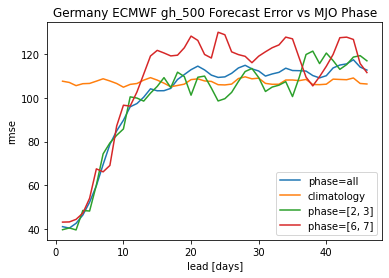

In [10]:
# calculate skill for each phase and lag combination, and plot vs lead time
# instead of looping could add all to same hindcast ensemble with extra dimension phase, then do .plot(hue='phase')
legend = []

# all data
hind = climpred.HindcastEnsemble(init).add_observations(obs).compute()
skill = hind.verify(**verify_kwargs, reference='climatology')
skill[variable].plot(hue='skill')
    
legend.append('phase=all')
legend.append('climatology')

# specific phases, amplitude>1
for phase in phases:
    hind = climpred.HindcastEnsemble(single_mjo_phase_init_aligned(init,mjodata,phases=phase)).add_observations(obs).compute()
    skill = hind.verify(**verify_kwargs)
    skill[variable].plot()
    
    legend.append('phase='+str(phase))

    
plt.legend(legend)#,loc='center right',bbox_to_anchor=(1.4,0.5))
plt.ylabel(verify_kwargs['metric'])
plt.title(region + ' ' + model + ' ' + variable + ' Forecast Error vs MJO Phase')

## Geospatial data

this is mostly copied from the tutorial notebook, but now calculates difference in skill between all inits and only MJO phases 6+7

In [12]:
import numpy as np
import xarray as xr
import climpred
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)
climpred.set_options(warn_for_failed_PredictionEnsemble_xr_call=False)

import cartopy.crs as ccrs

In [13]:
# cluster started from cluster.ipynb via ncar_jobqueue.NCARCluster, adaptive `cluster.adapt(minimum_jobs=1,maximum_jobs=24)` more economical or scale `cluster.scale(jobs=12)`
from dask.distributed import Client
client = Client("tcp://10.12.206.53:34490") # exchange IP with what you get in cluster.ipynb

In [14]:
# load big geospatial data 
model = 'ECMWF' # ECCC, NCEP  # forecast model
data = 'anom' # raw # anom means anomaly and means that climatology is removed
dim = 'geospatial' # geospatial  # spatial aggregatation
lead = 'biweekly' # biweekly  # lead aggregation

In [15]:
import intake
cat = intake.open_catalog('ASP_data_catalog.yml')
init = cat[model](data=data, lead=lead, dim=dim).to_dask()
obs = cat['OBS'](data=data, lead=lead, dim=dim).to_dask()

In [16]:
# choose a variable here: 
v='gh_500'
he = climpred.HindcastEnsemble(init).add_observations(obs)[[v]] # select only one variable
hemjo = climpred.HindcastEnsemble(single_mjo_phase_init_aligned(init,mjodata,phases=[6,7])).add_observations(obs)[[v]]
he.nbytes*1e-9, 'GB'

(5.927026384, 'GB')

In [17]:
# verification keywords
rmse_kwargs = dict(metric='rmse', comparison='e2o', dim='init', alignment='maximize', skipna=True)

In [18]:
# time and init should have only one chunk if init is in dim
he = he.chunk({'time':-1,'lon':20}).chunk({'init':-1,'lead':1,'lon':20}).persist()
hemjo = hemjo.chunk({'time':-1,'lon':20}).chunk({'init':-1,'lead':1,'lon':20}).persist()

%time rmse = he.verify(**rmse_kwargs)
rmsemjo = hemjo.verify(**rmse_kwargs)
client.dashboard_link

CPU times: user 4.52 s, sys: 126 ms, total: 4.65 s
Wall time: 4.53 s


'https://https://jupyterhub.hpc.ucar.edu/stable/user/mdavison/proxy/{port}/status'

CPU times: user 64.4 ms, sys: 5.29 ms, total: 69.7 ms
Wall time: 2.11 s


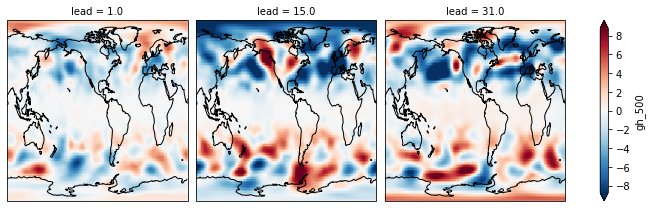

In [20]:
rmsediff = (rmse - rmsemjo)#/rmse
%time rmsediff = rmsediff.compute()
fg = rmsediff[v].plot(col='lead', 
                      transform=ccrs.PlateCarree(),  # remember to provide this for cartopy!
                      subplot_kws={
                          "projection": ccrs.PlateCarree(central_longitude=-100),
                          "aspect": 2
                      },
                      robust=True)
fg.map(lambda: plt.gca().coastlines())

red = better skill when mjo present at initialization, blue = worse

### over seasons

In [21]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [22]:
rmse_seasons = []
label_seasons = []
# Loops through all inits for a given season.
for label_season, group in tqdm(he.get_initialized().groupby("init.season")):
    # select only season inits
    rmse_season = he.sel(init=group.init).verify(**rmse_kwargs)
    rmse_seasons.append(rmse_season)
    label_seasons.append(label_season)
rmse_seasons = xr.concat(rmse_seasons, dim="season").assign_coords(season=label_seasons)

100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


In [23]:
rmse_seasonsmjo = []
label_seasonsmjo = []
# Loops through all inits for a given season.
for label_season, group in tqdm(hemjo.get_initialized().groupby("init.season")):
    # select only season inits
    rmse_season = hemjo.sel(init=group.init).verify(**rmse_kwargs)
    rmse_seasonsmjo.append(rmse_season)
    label_seasonsmjo.append(label_season)
rmse_seasonsmjo = xr.concat(rmse_seasonsmjo, dim="season").assign_coords(season=label_seasonsmjo)

100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


In [24]:
%time rmse_seasons = rmse_seasons.compute()
rmse_seasonsmjo = rmse_seasonsmjo.compute()

CPU times: user 157 ms, sys: 7.69 ms, total: 165 ms
Wall time: 1.94 s


In [25]:
rmse_seasons_diff = (rmse_seasons - rmse_seasonsmjo)#/rmse_seasons

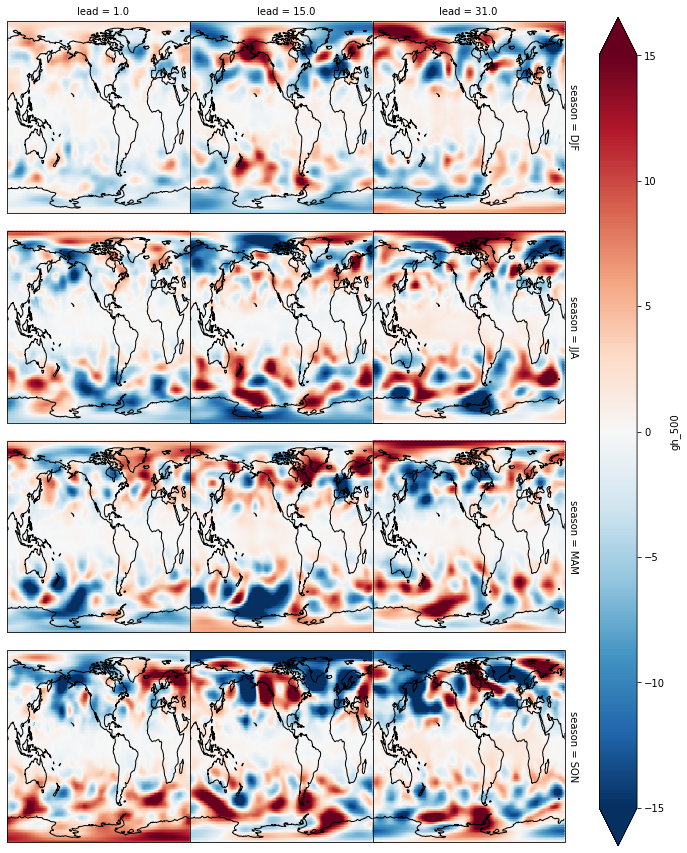

In [26]:
fg = rmse_seasons_diff[v].plot(col='lead', 
                               row='season', 
                               transform=ccrs.PlateCarree(),  # remember to provide this for cartopy!
                               subplot_kws={
                                   "projection": ccrs.PlateCarree(central_longitude=-100),
                                   "aspect": 2
                               },
                               robust=True)
fg.map(lambda: plt.gca().coastlines())

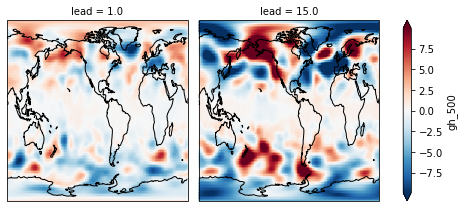

In [27]:
# DJF only plot for presentation
fg = rmse_seasons_diff[v].sel(season='DJF',lead=[1,15]).plot(col='lead', 
                                                             transform=ccrs.PlateCarree(),  # remember to provide this for cartopy!
                                                             subplot_kws={
                                                                 "projection": ccrs.PlateCarree(central_longitude=-100),
                                                                 "aspect": 2
                                                             },
                                                             robust=True)
fg.map(lambda: plt.gca().coastlines())

#plt.suptitle('rmse(all phases)-rmse(phases 6,7), season=DJF',y=1.05)

In [28]:
#plt.contour(obs.coords['lat'].values,obs.coords['lon'].values,(obs['t2m'].mean('time')<1), levels=0)

In [29]:
[ # Stop before reaching old untested code if running whole notebook

SyntaxError: unexpected EOF while parsing (2502498512.py, line 1)

 ## old version

Section below aligned to init+lead, with optional days of lag time between MJO phase and init+lead time. Code is slow, and messy. 

### Old Functions

In [30]:
# add mjo data to init, slower but includes more general options like match to init+lead
# could definitely be optimised if I had more knowledge of python
def add_mjo_data(init,mjodata,lag=0,alignment='init'):
    '''
    add mjo phase and amplitude data to init as new data variables
    aligned such that aligment-lag(days) = mjo date. lag is an arbitrary shift
    aligmnent = 'init' or 'init+lead'
    '''
    # get lead and init values
    leads = init.coords['lead'].values
    inits = init.coords['init'].values

    if alignment == 'init':
        shifttime = -lag
    elif alignment == 'init+lead':
        shifttime - int(leads[i])-lag
    
    # can do more quickly without loops. 
    # e.g init=init.sel[lead=mjodata.where(mjodata.phase==1,drop=True).where(mjodata.amplitude>1,drop=True).coords('time')]
    
    # creates matrix of data for mjo phase and amplitude vs init and lead
    mjoleadinitdata = np.empty((leads.size,inits.size,2))
    for i in range(leads.size):
        for j in range(inits.size):
            # Calcualte init+lead. Lead must be in days, else change 'D' to 'H','M', etc
            if leads[i]>0:
                currentdate = climpred.utils.shift_cftime_singular(inits[j],shifttime,'D')
            else:
                currentdate = inits[j]
            if currentdate < cftime.DatetimeProlepticGregorian(2021,1,1):
                mjoleadinitdata[i,j,:] = [mjodata.sel(time=currentdate).phase,mjodata.sel(time=currentdate).amplitude]
                
    # turn matrix into xarray dataset
    mjophasesleadinit = xr.Dataset(
        data_vars=dict(
            phase=(['init','lead'],mjoleadinitdata[:,:,0].T),
            amplitude=(['init','lead'],mjoleadinitdata[:,:,1].T),
        ),
        coords=dict(
            init=inits,
            lead=leads,
        ),
    )       
               
    # merge with init s.t. init has mjo phase and amplitude data
    init = init.combine_first(mjophasesleadinit).sel(init=init.coords['init'])    
    return init

# select single phase once mjo data is added to init
def single_mjo_phase(init,phase=int,drop=False):
    '''replances all data in init with nan, unless mjo phase at time=init+lead-lag(days) is phase'''
    init = init.where(init.amplitude>1,drop=drop).where(init.phase==phase,drop=True)
    
    return init

In [31]:
#init = add_mjo_data(init,mjodata)

### State Dependence Stuff (Old)

In [32]:
# Mjo phase and time lags to calculate
phases = [2,4,6,8]
lags = [0]

In [33]:
verify_kwargs = dict(metric='rmse', # https://climpred.readthedocs.io/en/stable/metrics.html
                    comparison='e2o', # compare ensemble member mean to observations - https://climpred.readthedocs.io/en/stable/comparisons.html
                    dim=[], # reduce this dimension, equivalent to dim in xarray, don't always need to reduce any dim, eg with rmse
                    alignment='maximize', # https://climpred.readthedocs.io/en/stable/alignment.html
                    keep_attrs=True, skipna=True) # passed to xs.metric

In [34]:
# calculate skill for each phase and lag combination, and plot vs lead time
legend = []
for lag in lags:
    initdata = add_mjo_data(init,mjodata,lag=lag,alignment='init')
    for phase in phases:
        hind = climpred.HindcastEnsemble(single_mjo_phase(initdata,phase=phase)).add_observations(obs).compute()
        skill = hind.verify(**verify_kwargs)
        skill['t2m'].plot(hue='skill')
        
        legend.append('phase='+str(phase)+', lag='+str(lag))
        #legend.append('_nolabel_')

        
#legend[-1] = 'persistence'
plt.legend(legend,loc='center right',bbox_to_anchor=(1.4,0.5))
plt.ylabel('rmse')
plt.title(region + ' t2m Forecast Error vs MJO Phase')

KeyboardInterrupt: 

In [ ]:
hind = climpred.HindcastEnsemble(single_mjo_phase(initdata,phase=phase)).add_observations(obs).compute()
skill = hind.verify(**verify_kwargs)
print(skill)

In [ ]:
skill.t2m.plot()

# Task 1 

hints

# Task 2

hints